In [2]:


import networkx as nx
import pandas
from tqdm import trange, tqdm
import clustering
import graph_generator
import numpy as np
import random
from matplotlib import pyplot as plt


In [3]:
G = graph_generator.get_graph('R6564910')
Q = nx.Graph()
for u, d in G.nodes(data=True):
    Q.add_node(u, x=d['x'], y=d['y'])
for u, v, d in G.edges(data=True):
    if u != v:
        Q.add_edge(u, v, length=d['length'])
del G
G = Q

In [4]:


def resolve(G:nx.Graph, k :int, max_iter:int = 1, draw:bool = True) -> list[set[int]]:
    nodes = G.nodes()
    sample = random.sample(nodes, k)
    need_update = True
    iter = 0
    center_to_nodes = {}
    while need_update and iter < max_iter:
        iter+=1
        nodes_to_dst = {u: float('inf') for u in nodes}
        nodes_to_center = {u: None for u in nodes}
        for s in tqdm(sample, desc=f'find shortest paths {iter}'):
            lengths = nx.single_source_dijkstra_path_length(G, s, weight='length')
            for u in nodes:
                if lengths[u] < nodes_to_dst[u]:
                    nodes_to_dst[u] = lengths[u]
                    nodes_to_center[u] = s
        center_to_nodes = {c : [] for c in sample}
        for u in nodes_to_center:
            center_to_nodes[nodes_to_center[u]].append(u)
        new_centers = set()
        for c in tqdm(center_to_nodes, desc=f'find new center {iter}'):
            s = G.subgraph(center_to_nodes[c])
            centers = nx.barycenter(s, weight='length')
            new_centers.add(centers[0])
        if len(set(sample).difference(new_centers)) > 0:
            need_update = True
            sample = list(new_centers)
        else:
            need_update = False
        if draw:
            res = []
            for u in center_to_nodes:
                res.append(set(center_to_nodes[u]))
            clustering.CommunitiesResolver.write_communities(G, communities)
            
            pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
            fig, axs = plt.subplots(1, 1)
            fig.set_figwidth(20)
            fig.set_figheight(20)
            cmap = plt.get_cmap('tab10')
            colors = [cmap(d['cluster']/len(communities)) for u,d in G.nodes(data=True)]
            nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)
            plt.show(fig)
    res = []
    for u in center_to_nodes:
        res.append(set(center_to_nodes[u]))
    return res

In [5]:
G.nodes()[5563345998]

{'x': 60.5928332, 'y': 56.8015486}

In [6]:
# communities = resolve(G, 10, max_iter=10)
# clustering.CommunitiesResolver.write_communities(G, communities)

KeyError: 'cluster'

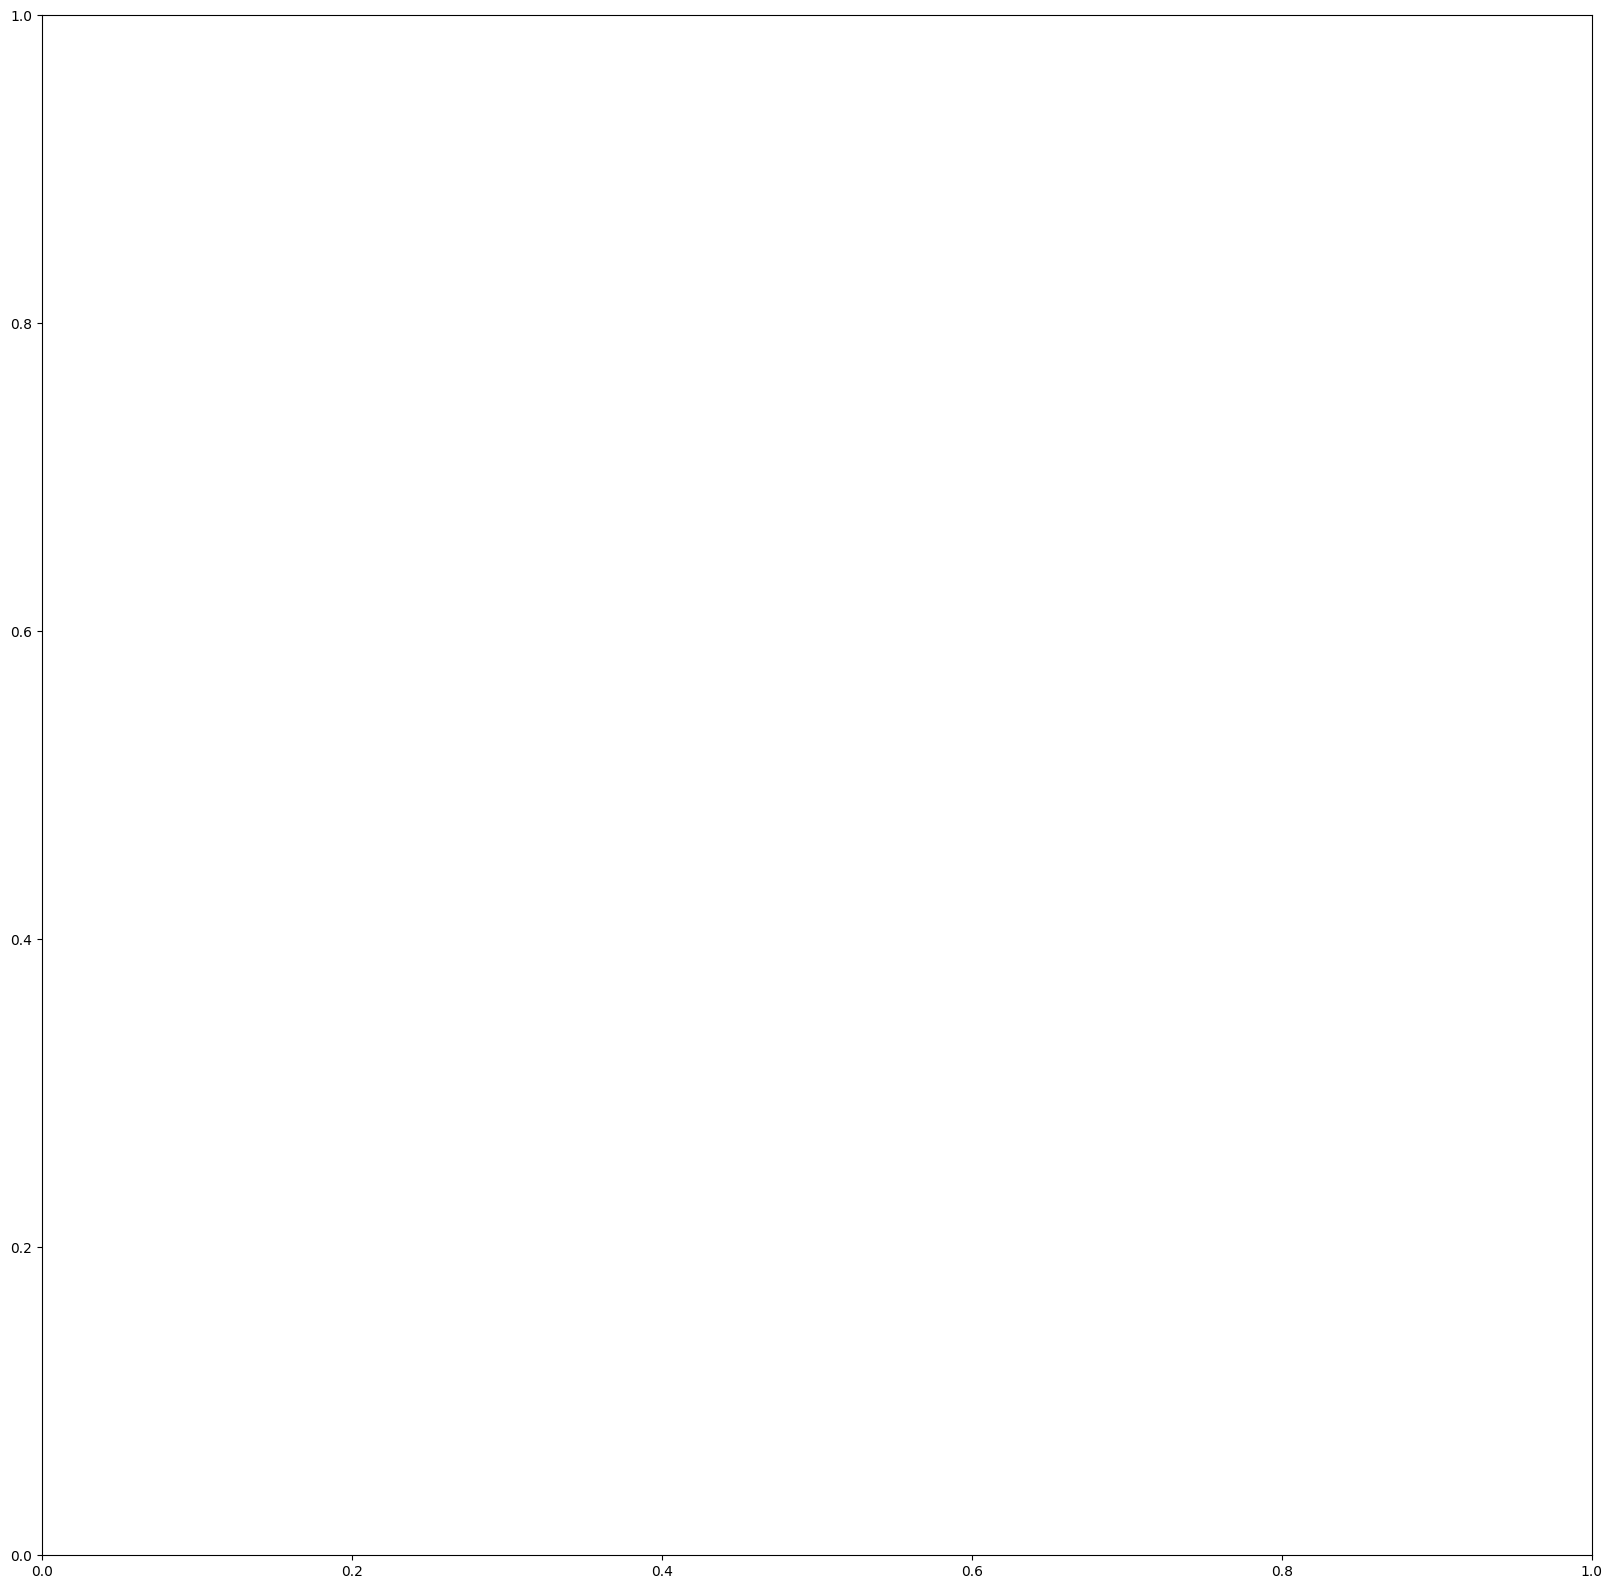

In [7]:

pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20) 
cmap = plt.get_cmap('tab10')
colors = [cmap(d['cluster']/len(communities)) for u,d in G.nodes(data=True)]
nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[d['x'], d['y']] for u,d in G.nodes(data=True)])
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X)

tmp = {i:u for i,u in enumerate(G.nodes())}

for i, l in enumerate(kmeans.labels_):
    G.nodes()[tmp[i]]['cluster'] = l

In [ ]:
count = len(set(kmeans.labels_))
cms = []
for i in range(count):
    cms.append(set(filter(lambda x: G.nodes()[x]['cluster'] == i, [u for u in G.nodes()])))

In [ ]:
for i,c in enumerate(cms):
    g = G.subgraph(c)
    print(nx.is_connected(g))

In [ ]:
pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
cmap = plt.get_cmap('tab10')
label_dict = {u : d['cluster'] for u, d in G.nodes(data=True)}
colors = [cmap(d['cluster']/len(set(kmeans.labels_))) for u,d in G.nodes(data=True)]
nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)
nx.draw_networkx_labels(G, pos_G, labels=label_dict, font_size=8)


In [8]:
N = len(G.nodes())
# nx.dijkstra_path_length
dist = dict(tqdm(nx.all_pairs_bellman_ford_path_length(G, weight='length'), total=N*(N-1)/2))

  0%|          | 289/15387378.0 [00:19<288:00:29, 14.84it/s]


KeyboardInterrupt: 

In [11]:
g = G
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, BisectingKMeans
def f(a,b):
    print(a,b)
    u = int(a[2])
    v = int(b[2])
    if (u,v) in g.edges() or (v,u) in g.edges():
        return g.edges()[(u,v)]['length']
    return 10000
    # return nx.single_source_dijkstra(g, u,v,weight='length')[0]
scan = KMeans(n_clusters=20, init = f)
x = np.array([[d['x'], d['y'], u] for u, d in g.nodes(data=True)])
y = scan.fit_predict(x)
communities = {}
for i, u in enumerate(g.nodes):
    cls = y[i]
    if cls not in communities:
        communities[cls] = set()
    communities[cls].add(u)
communities = [communities[cls] for cls in communities]
cls = []
for i, c in enumerate(communities):
    for n in nx.connected_components(g.subgraph(c)):
        cls.append(n)
for i, ids in enumerate(cls):
    for j in ids:
        g.nodes()[j]['cluster'] = i
cms = cls
print(len(cms))
communities = cms
pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
cmap = plt.get_cmap('plasma')
label_dict = {u : d['cluster'] for u, d in G.nodes(data=True)}
colors = [cmap(d['cluster']/len(cls)) for u,d in G.nodes(data=True)]
nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)
# nx.draw_networkx_labels(G, pos_G, labels=label_dict, font_size=8)

TypeError: f() got an unexpected keyword argument 'random_state'

In [ ]:
pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
cmap = plt.get_cmap('tab10')
label_dict = {u : d['cluster'] for u, d in G.nodes(data=True)}
colors = [cmap(d['cluster']/len(communities)) for u,d in G.nodes(data=True)]
nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)
# nx.draw_networkx_labels(G, pos_G, labels=label_dict, font_size=8)